### One of the methods is using a already trained model on a Generic Dataset like ImageNet and use the concept of Transfer Learning to fine tune the model for the new dataset.

ImageNet model is one of the largest Image Classification projects with 1000 classes and 1.4 million images. All famous architecture for CNN are availabe in Keras which are pre trained on the ImageNet dataset. Most commonly used CNN architectures are VGG16, devloped in 2014, ResNets, Inception, Xception, etc

Here we will be starting with the VGG16 architecture as it is easier to understand based on the layers learned till now, and easy to replicate. The architectures like ResNet use special techniqes for optimizations which will be covered later.

***The pretrained network can be used in 2 ways, one for feature extraction and another for fine-tuning***

### Feature Extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

Consider this 3 step Process - 
1. Training a end to end network i.e. (CNN Base + Classifier) on some general dataset. 
2. Replacing the Classifier with a new classifer and freezing the CNN Base. 
3. Training the model from step 2 on a new dataset. 

This is esentially what we are going to do. The step 1 as been already been done for us. So, we will use Keras pretrained model and train the Clssifier on top of it's CNN Base which acts as a feature extractor. This is also called as Transfer Learning. 

The Dense layers are discarded as the features learned by Dense layers are not generizable, whereas the features learned by the CNN base asre quite generizable. 

For some applications even the CNN Base might require some fine tuning which we will study in the next section. 

> models can be imported from keras.applications

In the following code we use the VGG16 model available in the Keras Applications. 

In [1]:
from keras.applications import VGG16

Using TensorFlow backend.


### The parameters passed while importing the model are - 
1. Weights checkpoint - Here ImageNet dataset
2. include_top refers to whether the Dense layers are required or not.
3. input_shape defines the size of the image.

In [3]:
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150,150,3))

58892288/58889256 [==============================] - 10s 0us/step


In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

***Check the dimesnions of the final feature map as we will be attaching the Dense layer on Top of that***

```latex
    Final Feature Map: (4,4,12)
    No. of neurons in the first Dense layer = 4*4*512 = 8192
```

**Now, there are two ways in which we can use this Convolutional Base -** 

1. Running the Convolutional Base over the dataset, recording its output to a Numpy array on disk, and then using this data as input to a standalone, densely connected classifier. *This solution is fast and cheap to run, because it only requires running the CNN Once for every image and CNN is the most computationally expensive part of the model. But this would not allow us to use Data Augmentation.*
2. Extending the model and adding the dense layers on top of it. Here we will be running the model end to end multiple times. So this process even though expensive would allow us to use the Data Generators. 


**One solution to the first problem would be Augmenting the data and writing it to the disk. Then using the Conv base model on it to extract features. Then running only the Dense Network for training the classifier.**

### In this notebook we will first start with the first technique described above. 

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [6]:
## Refer Notebook Ch-5.2 for the creation of the dataset using the Kaggle's Cats_vs_Dogs Dataset

base_dir = '/home/yash/Datasets/dogs-vs-cats-small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [7]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20 

In [8]:
## Function creates a simple datagen and runs all the batches through the Conv_base to create a new feature array
## It returns the features extracted from the conv_base along with the original labels

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count,4,4,512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                           target_size=(150,150),
                                           batch_size = batch_size,
                                           class_mode = 'binary')
    i = 0 
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size : (i+1)*batch_size] = features_batch
        labels[i*batch_size : (i+1)*batch_size] = labels_batch
        i+=1
        if i*batch_size >= sample_count:
            break
    return features, labels

In [16]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [17]:
### Now we have extracted the features for all the samples. 
### The dimensions of the features are based on the number of samples and
### output dimesnions of the conv_base

train_features.shape

(2000, 4, 4, 512)

***Now we need to respahpe this so that we can feed the extracted features to the Dense Neural Network we are going to create. The Dense neural Network input parameters shape is (samples, features) i.e. 2D tensor, whereas we now have a 4D tensor. So we will be performing the flatten operation using numpy.***

In [18]:
train_features = np.reshape(train_features, (train_features.shape[0], train_features.shape[1]*train_features.shape[2]*train_features.shape[3]))
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1]*test_features.shape[2]*test_features.shape[3]))
validation_features = np.reshape(validation_features, (validation_features.shape[0], validation_features.shape[1]*validation_features.shape[2]*validation_features.shape[3]))

In [19]:
train_features.shape

(2000, 8192)

In [20]:
test_features.shape

(1000, 8192)

In [21]:
validation_features.shape

(1000, 8192)

### Starrting with the Dense Model

In [22]:
from keras import models
from keras import layers
from keras import optimizers

In [24]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=8192))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))

In [25]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(loss='binary_crossentropy',
             optimizer = optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

In [27]:
history = model.fit(train_features, 
                    train_labels,
                    epochs = 30,
                    batch_size = 20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 372us/step - loss: 0.6203 - acc: 0.6445 - val_loss: 0.4534 - val_acc: 0.8210
Epoch 2/30
2000/2000 [==============================] - 0s 215us/step - loss: 0.4354 - acc: 0.8030 - val_loss: 0.3761 - val_acc: 0.8320
Epoch 3/30
2000/2000 [==============================] - 0s 215us/step - loss: 0.3612 - acc: 0.8435 - val_loss: 0.3423 - val_acc: 0.8450
Epoch 4/30
2000/2000 [==============================] - 0s 214us/step - loss: 0.3157 - acc: 0.8650 - val_loss: 0.3244 - val_acc: 0.8560
Epoch 5/30
2000/2000 [==============================] - 0s 218us/step - loss: 0.2922 - acc: 0.8790 - val_loss: 0.3080 - val_acc: 0.8610
Epoch 6/30
2000/2000 [==============================] - 0s 225us/step - loss: 0.2748 - acc: 0.8925 - val_loss: 0.3012 - val_acc: 0.8680
Epoch 7/30
2000/2000 [==============================] - 0s 231us/step - loss: 0.2531 - acc: 0.9030 - val_loss: 0.2922 - val_acc: 0.8680


In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

In [31]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

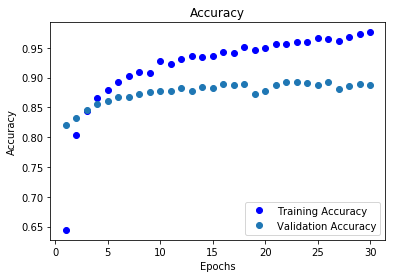

In [32]:
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'o', label='Validation Accuracy')

plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

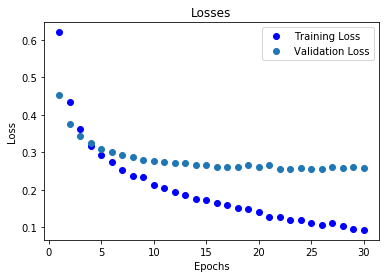

In [33]:
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'o', label='Validation Loss')


plt.title('Losses')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

-----------------------------------------------------------------------------------------------------------------

### Now using the second approach i.e. Training the model using the VGG16 end to end pipeline by adding the Dense Layers at he end. Here we will also get to use the Data Augmentation. 



-----------------------------------------------------------------------------------------------------------------


***Important point before starting this section: The models act as layers and can be added to the network using the same Method. This is one of the features of Keras which allows modularity.***

In [34]:
from keras import models
from keras import layers

In [35]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


----------------------------------------------------------------------------------------------------------------

### Freezing the Parameters of the VGG16 model before starting to train is important. As here our aim is not to fine tune the VGG16 feature extractor to our model but use it just to extract features. The model's different layers can also be frozen depending uopon requirements, which is one thing we will try next.


----------------------------------------------------------------------------------------------------------------

In Keras thw weights for a layer can be frozen by setting the model.trainable as False. 

In [37]:
print('This is the number of parameters before freezing conv_base: ', len(model.trainable_weights))

This is the number of parameters before freezing conv_base:  30


In [38]:
conv_base.trainable = False

In [39]:
print('This is the number of parameters after freezing conv_base: ', len(model.trainable_weights))

This is the number of parameters after freezing conv_base:  4


In [40]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

In [41]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                             rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode = 'nearest')

test_datagen = ImageDataGenerator(rescale = 1./255)

In [42]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size = (150,150),
                                                   batch_size = 32,
                                                   class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                   target_size = (150,150),
                                                   batch_size = 32,
                                                   class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [43]:
model.compile(optimizer = optimizers.RMSprop(lr=2e-5),
             loss = 'binary_crossentropy',
             metrics = ['acc'])

In [44]:
### Fitting the model using the Data Generator created

history = model.fit_generator(train_generator,
                             steps_per_epoch = 100,
                             epochs = 50,
                             validation_data = validation_generator,
                             validation_steps = 50)

Epoch 1/50
100/100 [==============================] - 31s 306ms/step - loss: 0.5566 - acc: 0.7272 - val_loss: 0.4143 - val_acc: 0.8414
Epoch 2/50
100/100 [==============================] - 28s 277ms/step - loss: 0.4540 - acc: 0.8031 - val_loss: 0.3520 - val_acc: 0.8486
Epoch 3/50
100/100 [==============================] - 28s 279ms/step - loss: 0.4205 - acc: 0.8103 - val_loss: 0.3432 - val_acc: 0.8591
Epoch 4/50
100/100 [==============================] - 28s 276ms/step - loss: 0.3911 - acc: 0.8206 - val_loss: 0.3071 - val_acc: 0.8789
Epoch 5/50
100/100 [==============================] - 27s 275ms/step - loss: 0.3694 - acc: 0.8403 - val_loss: 0.2963 - val_acc: 0.8725
Epoch 6/50
100/100 [==============================] - 28s 279ms/step - loss: 0.3584 - acc: 0.8378 - val_loss: 0.3121 - val_acc: 0.8673
Epoch 7/50
100/100 [==============================] - 27s 275ms/step - loss: 0.3432 - acc: 0.8475 - val_loss: 0.2881 - val_acc: 0.8763
Epoch 8/50
100/100 [==============================] - 2

In [45]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

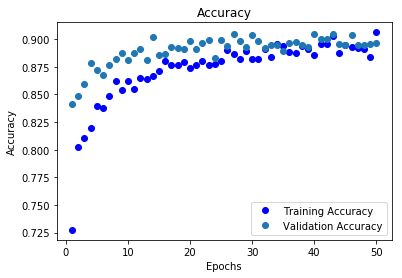

In [46]:
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'o', label='Validation Accuracy')

plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

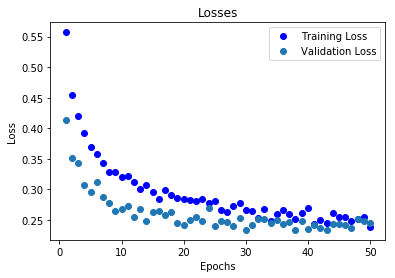

In [47]:
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'o', label='Validation Loss')


plt.title('Losses')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Fine Tuning the Model

**The way the Convolutional Neural Networks training happenms is very intuitive. The earlier layers try to capture the low level features like small patterns in the edges, whereas as we keep going deeper the feature maps start becoming more high level and clearly defined features. For object detection the last layer may features may involve the feature associated to the Object. For a Car it might the feature maybe the complete exo-skeleton of the car. So sometimes when usinmg transfer learning it is advised to unfreeze some of the last layers of the CNN and then train th model as this helps in getter problem specific features and remove some features which are not relevent when it comes to working with this probelem. 

--------------------------------------------------------------------------------------------------------------

### The steps for fine tuning the model are - 

1. Add thee custom network on top of an already-trained base network. 
2. Freeze the base network.
3. Train the part you added.
4. Unfreeze some layers in the Base Network. 
5. Jointly train both these layers and the part you added. 


-----------------------------------------------------------------------------------------------------------------
### So we are done with the first three steps till now.
-----------------------------------------------------------------------------------------------------------------

In [48]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

***We will be fine tuning the last three COnvolutional Layers - So layers uptill the block4_pool will remain frozen, and the last three layers i.e. block5_conv1, block5_conv2, block5_conv3 should be trainable.***

In [49]:
conv_base.trainable = True

In [50]:
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_Trainable = True
    if set_trainable:
        layer.Trainable = True
    else:
        layer_Trainable = False

In [51]:
### During fine tuning we use a very low learning rate as we 
### do not need to damage the representations learned earlier

model.compile(optimizer = optimizers.RMSprop(lr=1e-5),
             loss = 'binary_crossentropy',
             metrics = ['acc'])

In [52]:
### Fitting the model using the Data Generator created

history = model.fit_generator(train_generator,
                             steps_per_epoch = 100,
                             epochs = 100,
                             validation_data = validation_generator,
                             validation_steps = 50)

Epoch 1/100
100/100 [==============================] - 42s 423ms/step - loss: 0.2529 - acc: 0.9009 - val_loss: 0.1895 - val_acc: 0.9308
Epoch 2/100
100/100 [==============================] - 36s 363ms/step - loss: 0.1799 - acc: 0.9253 - val_loss: 0.1509 - val_acc: 0.9439
Epoch 3/100
100/100 [==============================] - 36s 364ms/step - loss: 0.1520 - acc: 0.9369 - val_loss: 0.1155 - val_acc: 0.9556
Epoch 4/100
100/100 [==============================] - 38s 376ms/step - loss: 0.1053 - acc: 0.9559 - val_loss: 0.1089 - val_acc: 0.9613
Epoch 5/100
100/100 [==============================] - 38s 376ms/step - loss: 0.1021 - acc: 0.9597 - val_loss: 0.1058 - val_acc: 0.9646
Epoch 6/100
100/100 [==============================] - 37s 375ms/step - loss: 0.0920 - acc: 0.9647 - val_loss: 0.1001 - val_acc: 0.9626
Epoch 7/100
100/100 [==============================] - 37s 374ms/step - loss: 0.0771 - acc: 0.9687 - val_loss: 0.1122 - val_acc: 0.9665
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 36s 365ms/step - loss: 0.0043 - acc: 0.9994 - val_loss: 0.1951 - val_acc: 0.9657
Epoch 62/100
100/100 [==============================] - 37s 366ms/step - loss: 0.0061 - acc: 0.9978 - val_loss: 0.2237 - val_acc: 0.9659
Epoch 63/100
100/100 [==============================] - 36s 365ms/step - loss: 0.0134 - acc: 0.9972 - val_loss: 0.2674 - val_acc: 0.9607
Epoch 64/100
100/100 [==============================] - 36s 364ms/step - loss: 0.0056 - acc: 0.9978 - val_loss: 0.2209 - val_acc: 0.9716
Epoch 65/100
100/100 [==============================] - 37s 366ms/step - loss: 0.0045 - acc: 0.9978 - val_loss: 0.2394 - val_acc: 0.9651
Epoch 66/100
100/100 [==============================] - 36s 364ms/step - loss: 0.0071 - acc: 0.9975 - val_loss: 0.2151 - val_acc: 0.9710
Epoch 67/100
100/100 [==============================] - 37s 366ms/step - loss: 0.0058 - acc: 0.9978 - val_loss: 0.2584 - val_acc: 0.9638
Epoch 68/100
100/100 [===================

In [56]:
def smooth_curve(points, factor = 0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [57]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

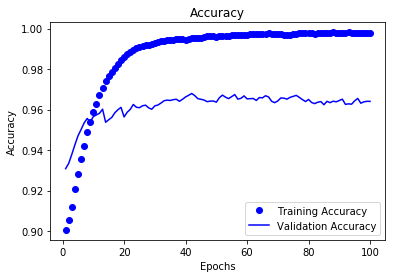

In [58]:
plt.plot(epochs, smooth_curve(acc), 'bo', label='Training Accuracy')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Validation Accuracy')

plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

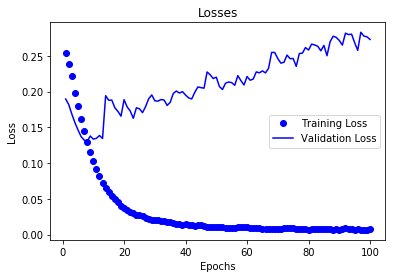

In [59]:
plt.plot(epochs, smooth_curve(loss), 'bo', label='Training Loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Validation Loss')


plt.title('Losses')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### It is quite clear that the model started overfitting after the 10th epoch. 

In [61]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=(150,150),
                                                 batch_size = 20,
                                                 class_mode = 'binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test_acc: ', test_acc)

Found 1000 images belonging to 2 classes.
test_acc:  0.9709999930858612
